# Forecasting
In this notebook we will begin to forecast future visitors for restuarants in Air's dataset.  Instead of taking the data as it is we will fill in missing dates with visitors=0. Its important for time series data to have values at steady intervals when calculating moving averages.  Before we try a variety of models we will feature engineer some features that might be useful.

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit

In [25]:
air_reserve = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/air_reserve.csv')
air_store_info = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/air_store_info.csv')
air_visit_data = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/air_visit_data.csv')
date_info = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/date_info.csv')
hpg_reserve = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/hpg_reserve.csv')
hpg_store_info = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/hpg_store_info.csv')
store_id_relation = pd.read_csv('/Users/luken2/Documents/GitHub/restaurant-forecasting/data/store_id_relation.csv')

In [57]:
air_visit_data.index = pd.to_datetime(air_visit_data['visit_date'])
air_visit_data = air_visit_data.groupby('air_store_id').apply(lambda x: x['visitors'].resample('1d').sum()).reset_index()
air_visit_data['visit_date'] = air_visit_data['visit_date'].dt.strftime('%Y-%m-%d')
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])

In [58]:
air_visit_data.head()

,air_store_id,visit_date,visitors
0,air_00a91d42b08b08d9,2016-07-01,35
1,air_00a91d42b08b08d9,2016-07-02,9
2,air_00a91d42b08b08d9,2016-07-03,0
3,air_00a91d42b08b08d9,2016-07-04,20
4,air_00a91d42b08b08d9,2016-07-05,25


## Feature Engineering
Feature engineering can help give our models more predictive power.  We are going to make new features of
1. Holidays
2. Weekdays
3. Months

In [59]:
date_info.rename(columns={'calendar_date': 'visit_date', 'holiday_flg': 'is_holiday'}, inplace=True)

date_info['visit_date'] = pd.to_datetime(date_info['visit_date'])
date_info['prev_day_was_holiday'] = date_info['is_holiday'].shift().fillna(0)
date_info['next_day_is_holiday'] = date_info['is_holiday'].shift(-1).fillna(0)

date_info.head()

,visit_date,day_of_week,is_holiday,prev_day_was_holiday,next_day_is_holiday
0,2016-01-01,Friday,1,0.0,1.0
1,2016-01-02,Saturday,1,1.0,1.0
2,2016-01-03,Sunday,1,1.0,0.0
3,2016-01-04,Monday,0,1.0,0.0
4,2016-01-05,Tuesday,0,0.0,0.0


In [70]:
df = pd.merge(left=air_visit_data, right=date_info, on='visit_date', how='left')
df = pd.merge(left=df, right=air_store_info, on='air_store_id', how='left')

df.head()

,air_store_id,visit_date,visitors,day_of_week,is_holiday,prev_day_was_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,2016-07-01,35,Friday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_00a91d42b08b08d9,2016-07-02,9,Saturday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
2,air_00a91d42b08b08d9,2016-07-03,0,Sunday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
3,air_00a91d42b08b08d9,2016-07-04,20,Monday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
4,air_00a91d42b08b08d9,2016-07-05,25,Tuesday,0,0.0,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595


In [71]:
df['month'] = df['visit_date'].dt.month

In [72]:
def num_to_month(df, column):
    months = []
    for row in df[column]:
        if row == 1:
            months.append('Jan')
        elif row == 2:
            months.append('Feb')
        elif row == 3:
            months.append('Mar')
        elif row == 4:
            months.append('Apr')
        elif row == 5:
            months.append('May')
        elif row == 6:
            months.append('Jun')
        elif row == 7:
            months.append('Jul') 
        elif row == 8:
            months.append('Aug')
        elif row == 9:
            months.append('Sep')
        elif row == 10:
            months.append('Oct')
        elif row == 11:
            months.append('Nov')
        elif row == 12:
            months.append('Dec')
    df[column] = pd.Series(months)

In [73]:
num_to_month(df, 'month')

## SARIMA
Our first model is going to be seasonal auto regressive integrated moving average (SARIMA).  I'm going to leave the last two weeks for each restaurant as cross-validation data because we are only trying to forecast two weeks into the future.  Let's grab the first restaurant to forecast

In [86]:
df.groupby(['air_store_id']).mean().sort_values('visitors', ascending=False).head(10)

,visitors,is_holiday,prev_day_was_holiday,next_day_is_holiday,latitude,longitude
air_store_id,,,,,,
air_1c0b150f9e696a5f,113.250000,0.019231,0.019231,0.019231,35.661777,139.704051
air_9c6787aa03a45586,62.232558,0.023256,0.023256,0.023256,35.694003,139.753595
air_258dc112912fc458,51.527027,0.067568,0.067568,0.067568,35.706657,139.868427
air_a17f0778617c76e2,44.595745,0.021277,0.021277,0.021277,34.695124,135.197853
air_cf5ab75a0afb8af9,42.582090,0.014925,0.014925,0.014925,38.269076,140.870403
air_67f87c159d9e2ee2,41.456081,0.067568,0.067568,0.067568,33.581941,130.348436
air_168441ada3e878e1,41.182432,0.067568,0.067568,0.067568,34.720228,135.265455
air_4feeb8600f131e43,40.932432,0.067568,0.067568,0.067568,35.670651,139.771861
air_2703dcb33192b181,39.712766,0.074468,0.074468,0.074468,35.672854,139.817410


In [99]:
restaurant = df.loc[(df['air_store_id']=='air_399904bdb7685ca0')]

In [139]:
restaurant['visit_diff'] = restaurant['visitors'] - restaurant['visitors'].shift(1)
restaurant['log1p_visitors'] = np.log1p(restaurant['visitors'])
restaurant['visit_seasonal'] = restaurant['visitors'] - restaurant['visitors'].shift(7)
restaurant['visitors_seasonal_diff'] = restaurant['visit_diff'] - restaurant['visit_diff'].shift(7)

//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [239]:
restaurant.tail()

,air_store_id,visitors,day_of_week,is_holiday,prev_day_was_holiday,next_day_is_holiday,air_genre_name,air_area_name,latitude,longitude,month,visit_diff,log1p_visitors,visit_seasonal,visitors_seasonal_diff,forecast
visit_date,,,,,,,,,,,,,,,,
2017-04-18,air_399904bdb7685ca0,31,Tuesday,0,0.0,0.0,Italian/French,Ōsaka-fu Ōsaka-shi Kyūtarōmachi,34.681261,135.509801,Apr,8.0,3.465736,8.0,-11.0,NaN
2017-04-19,air_399904bdb7685ca0,17,Wednesday,0,0.0,0.0,Italian/French,Ōsaka-fu Ōsaka-shi Kyūtarōmachi,34.681261,135.509801,Apr,-14.0,2.890372,1.0,-7.0,NaN
2017-04-20,air_399904bdb7685ca0,24,Thursday,0,0.0,0.0,Italian/French,Ōsaka-fu Ōsaka-shi Kyūtarōmachi,34.681261,135.509801,Apr,7.0,3.218876,-20.0,-21.0,NaN
2017-04-21,air_399904bdb7685ca0,20,Friday,0,0.0,0.0,Italian/French,Ōsaka-fu Ōsaka-shi Kyūtarōmachi,34.681261,135.509801,Apr,-4.0,3.044522,20.0,40.0,NaN
2017-04-22,air_399904bdb7685ca0,56,Saturday,0,0.0,0.0,Italian/French,Ōsaka-fu Ōsaka-shi Kyūtarōmachi,34.681261,135.509801,Apr,36.0,4.043051,6.0,-14.0,-3.230581


In [168]:
restaurant = restaurant.set_index('visit_date')

In [221]:
y = restaurant['visit_seasonal'].dropna(inplace=False)

In [235]:
y.tail()

visit_date
2017-04-18     8.0
2017-04-19     1.0
2017-04-20   -20.0
2017-04-21    20.0
2017-04-22     6.0
Name: visit_seasonal, dtype: float64

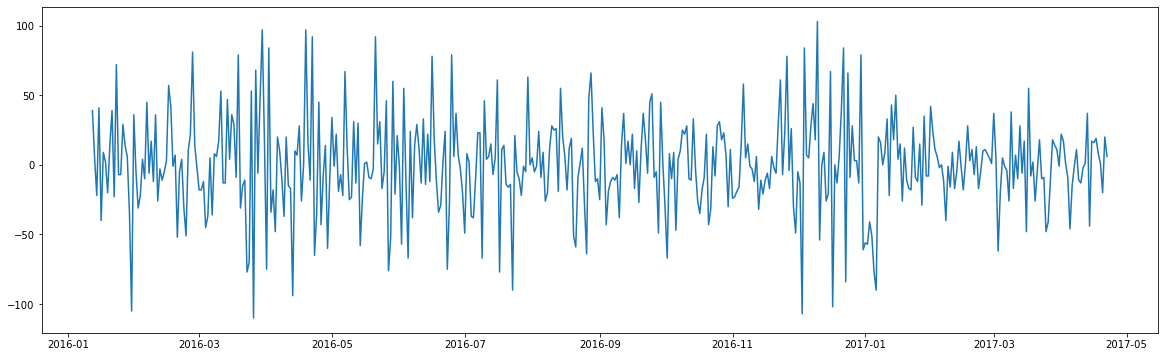

In [222]:
plt.figure(figsize=(20,6))
plt.plot(y)

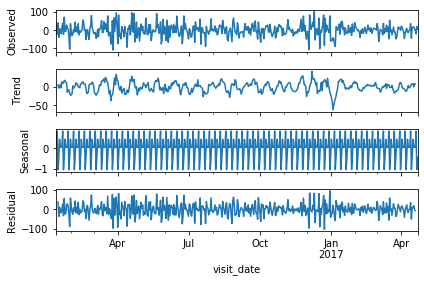

In [223]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

In [224]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [225]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 7)12 - AIC:4612.97740259442
ARIMA(0, 0, 0)x(0, 0, 1, 7)12 - AIC:4259.436050694152
ARIMA(0, 0, 0)x(0, 0, 2, 7)12 - AIC:4194.856183411546
ARIMA(0, 0, 0)x(0, 1, 0, 7)12 - AIC:5063.475184273565


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 7)12 - AIC:4504.9213776689085


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 2, 7)12 - AIC:4175.433847944373
ARIMA(0, 0, 0)x(0, 2, 0, 7)12 - AIC:5541.6136901160935


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 2, 1, 7)12 - AIC:4934.161417026216


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 2, 2, 7)12 - AIC:4408.664268670682
ARIMA(0, 0, 0)x(1, 0, 0, 7)12 - AIC:4401.822693728255
ARIMA(0, 0, 0)x(1, 0, 1, 7)12 - AIC:4260.99058934164


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 2, 7)12 - AIC:4194.959807893159
ARIMA(0, 0, 0)x(1, 1, 0, 7)12 - AIC:4695.277500093082


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 7)12 - AIC:4363.22404663206


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 2, 7)12 - AIC:4177.314465840724
ARIMA(0, 0, 0)x(1, 2, 0, 7)12 - AIC:5060.610480889641


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 2, 1, 7)12 - AIC:4650.2319212142975


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 2, 2, 7)12 - AIC:4282.748904454967
ARIMA(0, 0, 0)x(2, 0, 0, 7)12 - AIC:4298.253909445985


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 0, 1, 7)12 - AIC:4204.461582646083


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 0, 2, 7)12 - AIC:4196.661778226184
ARIMA(0, 0, 0)x(2, 1, 0, 7)12 - AIC:4495.525011164864


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 1, 1, 7)12 - AIC:4268.86830757946


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 1, 2, 7)12 - AIC:4178.889945411292
ARIMA(0, 0, 0)x(2, 2, 0, 7)12 - AIC:4778.001296089077


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 2, 1, 7)12 - AIC:4462.437545489323


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 2, 2, 7)12 - AIC:4255.626398909656
ARIMA(0, 0, 1)x(0, 0, 0, 7)12 - AIC:4603.572497068182
ARIMA(0, 0, 1)x(0, 0, 1, 7)12 - AIC:4252.178161145574


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 2, 7)12 - AIC:4188.331152372024
ARIMA(0, 0, 1)x(0, 1, 0, 7)12 - AIC:5051.549624209187


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 7)12 - AIC:4496.232398493707


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 2, 7)12 - AIC:4167.345378049738
ARIMA(0, 0, 1)x(0, 2, 0, 7)12 - AIC:5527.922191066957


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 2, 1, 7)12 - AIC:4922.207752498892


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 2, 2, 7)12 - AIC:4398.774717813936
ARIMA(0, 0, 1)x(1, 0, 0, 7)12 - AIC:4403.722763113212


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 7)12 - AIC:4253.587454337641


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 2, 7)12 - AIC:4187.569679595286
ARIMA(0, 0, 1)x(1, 1, 0, 7)12 - AIC:4696.856344719892


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 7)12 - AIC:4355.845065881107


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 2, 7)12 - AIC:4169.14921222985
ARIMA(0, 0, 1)x(1, 2, 0, 7)12 - AIC:5061.970282868657


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 2, 1, 7)12 - AIC:4641.250463259832


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 2, 2, 7)12 - AIC:4274.036129397704
ARIMA(0, 0, 1)x(2, 0, 0, 7)12 - AIC:4300.17889636787


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 0, 1, 7)12 - AIC:4206.3659850667555


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 0, 2, 7)12 - AIC:4189.411465879856


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 1, 0, 7)12 - AIC:4496.674487857639


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 1, 1, 7)12 - AIC:4270.787654296


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 1, 2, 7)12 - AIC:4170.8876827069125


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 2, 0, 7)12 - AIC:4778.427513373132


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 2, 1, 7)12 - AIC:4463.597918833455


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 2, 2, 7)12 - AIC:4246.682573241358
ARIMA(0, 0, 2)x(0, 0, 0, 7)12 - AIC:4595.789873025719


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 0, 1, 7)12 - AIC:4244.3106558620975


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 0, 2, 7)12 - AIC:4181.929943906602
ARIMA(0, 0, 2)x(0, 1, 0, 7)12 - AIC:5039.714013144755


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 1, 1, 7)12 - AIC:4489.474952612823


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 1, 2, 7)12 - AIC:4159.9491555367695
ARIMA(0, 0, 2)x(0, 2, 0, 7)12 - AIC:5513.34210667848
ARIMA(0, 0, 2)x(0, 2, 1, 7)12 - AIC:4911.477776732151


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 2, 2, 7)12 - AIC:4392.224409644891
ARIMA(0, 0, 2)x(1, 0, 0, 7)12 - AIC:4404.551372778319


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 0, 1, 7)12 - AIC:4245.670321404614


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 0, 2, 7)12 - AIC:4181.050862805418
ARIMA(0, 0, 2)x(1, 1, 0, 7)12 - AIC:4698.143470987824


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 1, 1, 7)12 - AIC:4347.443825217622


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 1, 2, 7)12 - AIC:4161.679529421801


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 2, 0, 7)12 - AIC:5063.89993907612


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 2, 1, 7)12 - AIC:4632.131595859168


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 2, 2, 7)12 - AIC:4265.1605834046295
ARIMA(0, 0, 2)x(2, 0, 0, 7)12 - AIC:4301.2854208737135


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 0, 1, 7)12 - AIC:4208.359060314581


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 0, 2, 7)12 - AIC:4182.934240182714


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 1, 0, 7)12 - AIC:4497.411824786701


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 1, 1, 7)12 - AIC:4271.891324374035


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 1, 2, 7)12 - AIC:4163.497265300494
ARIMA(0, 0, 2)x(2, 2, 0, 7)12 - AIC:4778.657500652591


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 2, 1, 7)12 - AIC:4464.362565518143


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 2, 2, 7)12 - AIC:4237.411520876243
ARIMA(0, 1, 0)x(0, 0, 0, 7)12 - AIC:4960.1033281743785
ARIMA(0, 1, 0)x(0, 0, 1, 7)12 - AIC:4565.112305338819


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 2, 7)12 - AIC:4489.551993950051
ARIMA(0, 1, 0)x(0, 1, 0, 7)12 - AIC:5413.300990249822
ARIMA(0, 1, 0)x(0, 1, 1, 7)12 - AIC:4836.572563678585


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 2, 7)12 - AIC:4472.212732155953
ARIMA(0, 1, 0)x(0, 2, 0, 7)12 - AIC:5888.576214215971


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 2, 1, 7)12 - AIC:5269.62167653354


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 2, 2, 7)12 - AIC:4730.406666886283
ARIMA(0, 1, 0)x(1, 0, 0, 7)12 - AIC:4716.854441322099
ARIMA(0, 1, 0)x(1, 0, 1, 7)12 - AIC:4561.979738996599


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 2, 7)12 - AIC:4488.938917898878
ARIMA(0, 1, 0)x(1, 1, 0, 7)12 - AIC:5011.881717480641


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 7)12 - AIC:4672.542924364668


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 2, 7)12 - AIC:4470.922767623502
ARIMA(0, 1, 0)x(1, 2, 0, 7)12 - AIC:5374.733585461858


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 2, 1, 7)12 - AIC:4961.117099742099


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 2, 2, 7)12 - AIC:4582.432836047006
ARIMA(0, 1, 0)x(2, 0, 0, 7)12 - AIC:4606.56683816686


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 0, 1, 7)12 - AIC:4498.981180336616


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 0, 2, 7)12 - AIC:4490.930283091589
ARIMA(0, 1, 0)x(2, 1, 0, 7)12 - AIC:4811.069171564412


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 1, 1, 7)12 - AIC:4571.894618750566


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 1, 2, 7)12 - AIC:4472.459907966023


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 2, 0, 7)12 - AIC:5093.689836359049


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 2, 1, 7)12 - AIC:4772.642217086255


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 2, 2, 7)12 - AIC:4551.419283393167
ARIMA(0, 1, 1)x(0, 0, 0, 7)12 - AIC:4602.304565978256


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 7)12 - AIC:4247.10600674158


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 2, 7)12 - AIC:4180.739967333219
ARIMA(0, 1, 1)x(0, 1, 0, 7)12 - AIC:5049.406101562748


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 7)12 - AIC:4499.144366962688


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 2, 7)12 - AIC:4172.105083518196


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 2, 0, 7)12 - AIC:5525.373688122401


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 2, 1, 7)12 - AIC:4926.115800644309


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 2, 2, 7)12 - AIC:4401.126445550537
ARIMA(0, 1, 1)x(1, 0, 0, 7)12 - AIC:4401.332935602788


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 7)12 - AIC:4248.25845199738


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 2, 7)12 - AIC:4181.181948717266


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 7)12 - AIC:4694.016639990892


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 7)12 - AIC:4358.08696297841


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 2, 7)12 - AIC:4173.424656606738


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 2, 0, 7)12 - AIC:5058.2760740013755


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 2, 1, 7)12 - AIC:4643.649853284988


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 2, 2, 7)12 - AIC:4278.0130833273


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 0, 0, 7)12 - AIC:4297.630252601167


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 0, 1, 7)12 - AIC:4198.673374362038


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 0, 2, 7)12 - AIC:4183.066852386334


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 1, 0, 7)12 - AIC:4494.477127677976


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 1, 1, 7)12 - AIC:4273.419908542161


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 1, 2, 7)12 - AIC:4175.407963343862
ARIMA(0, 1, 1)x(2, 2, 0, 7)12 - AIC:4776.123078775383


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 2, 1, 7)12 - AIC:4466.829372648387


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 2, 2, 7)12 - AIC:4251.963701674025
ARIMA(0, 1, 2)x(0, 0, 0, 7)12 - AIC:4591.692563744834


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 0, 1, 7)12 - AIC:4237.892339214528


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 0, 2, 7)12 - AIC:4173.279755475174


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 1, 0, 7)12 - AIC:5036.444757951985


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 1, 1, 7)12 - AIC:4488.80569400676


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 1, 2, 7)12 - AIC:4162.800369672175


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 2, 0, 7)12 - AIC:5511.359217404315


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 2, 1, 7)12 - AIC:4913.065940053277


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 2, 2, 7)12 - AIC:4391.938762609336


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 0, 0, 7)12 - AIC:4403.26035611499


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 0, 1, 7)12 - AIC:4239.054956398502


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 0, 2, 7)12 - AIC:4170.254747482239


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 1, 0, 7)12 - AIC:4695.65711076362


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 1, 1, 7)12 - AIC:4349.143171694312


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 1, 2, 7)12 - AIC:4164.149040165477


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 2, 0, 7)12 - AIC:5059.706981546189


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 2, 1, 7)12 - AIC:4632.3332808311125


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 2, 2, 7)12 - AIC:4269.622703942545


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 0, 0, 7)12 - AIC:4299.573829124123


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 0, 1, 7)12 - AIC:4200.4430114117795


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 0, 2, 7)12 - AIC:4172.247027701844


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 1, 0, 7)12 - AIC:4495.719093663996


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 1, 1, 7)12 - AIC:4275.357443560332


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 1, 2, 7)12 - AIC:4166.151742954876
ARIMA(0, 1, 2)x(2, 2, 0, 7)12 - AIC:4776.674543356774


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 2, 1, 7)12 - AIC:4468.07492171448


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 2, 2, 7)12 - AIC:4243.866030792915
ARIMA(0, 2, 0)x(0, 0, 0, 7)12 - AIC:5474.270470219924
ARIMA(0, 2, 0)x(0, 0, 1, 7)12 - AIC:5057.163784364566


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(0, 0, 2, 7)12 - AIC:4971.474242317932
ARIMA(0, 2, 0)x(0, 1, 0, 7)12 - AIC:5925.268508808717


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(0, 1, 1, 7)12 - AIC:5333.297539598265


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(0, 1, 2, 7)12 - AIC:4946.974063773978
ARIMA(0, 2, 0)x(0, 2, 0, 7)12 - AIC:6395.093953482501


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(0, 2, 1, 7)12 - AIC:5764.097746191307


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(0, 2, 2, 7)12 - AIC:5211.006234450952
ARIMA(0, 2, 0)x(1, 0, 0, 7)12 - AIC:5203.103096185923


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 0, 1, 7)12 - AIC:5049.672388226536


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 0, 2, 7)12 - AIC:4968.344058484403
ARIMA(0, 2, 0)x(1, 1, 0, 7)12 - AIC:5494.401881030062


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 1, 1, 7)12 - AIC:5149.66585903284


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 1, 2, 7)12 - AIC:4942.645902462858
ARIMA(0, 2, 0)x(1, 2, 0, 7)12 - AIC:5853.5288940288265


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 2, 1, 7)12 - AIC:5434.192533506131


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 2, 2, 7)12 - AIC:5044.220729953677
ARIMA(0, 2, 0)x(2, 0, 0, 7)12 - AIC:5084.520479628125


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 0, 1, 7)12 - AIC:4980.858931976514


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 0, 2, 7)12 - AIC:4970.342441548128
ARIMA(0, 2, 0)x(2, 1, 0, 7)12 - AIC:5284.147434494998


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 1, 1, 7)12 - AIC:5041.002213115817


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 1, 2, 7)12 - AIC:4943.459887017602


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 2, 0, 7)12 - AIC:5558.1091890653515


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 2, 1, 7)12 - AIC:5237.474355046248


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 2, 2, 7)12 - AIC:5011.301736100739
ARIMA(0, 2, 1)x(0, 0, 0, 7)12 - AIC:4945.944884242497


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 0, 1, 7)12 - AIC:4557.0911858633335


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 0, 2, 7)12 - AIC:4483.334617190771
ARIMA(0, 2, 1)x(0, 1, 0, 7)12 - AIC:5396.381193636732


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 1, 1, 7)12 - AIC:4827.955626501938


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 1, 2, 7)12 - AIC:4468.948080372363


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 2, 0, 7)12 - AIC:5870.408980443079


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 2, 1, 7)12 - AIC:5258.523315865684


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 2, 2, 7)12 - AIC:4719.90895430983


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 0, 0, 7)12 - AIC:4715.692972084051


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 0, 1, 7)12 - AIC:4554.103084576116


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 0, 2, 7)12 - AIC:4479.742185699462


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 1, 0, 7)12 - AIC:5009.886071848474


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 1, 1, 7)12 - AIC:4665.360188698705


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 1, 2, 7)12 - AIC:4467.7401416240855


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 2, 0, 7)12 - AIC:5371.707969007202


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 2, 1, 7)12 - AIC:4951.169466864673


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 2, 2, 7)12 - AIC:4574.893665011588


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 0, 0, 7)12 - AIC:4605.444829051403


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 0, 1, 7)12 - AIC:4502.460919481133


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 0, 2, 7)12 - AIC:4481.668109743752


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 1, 0, 7)12 - AIC:4809.26194509391


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 1, 1, 7)12 - AIC:4575.314070616529


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 1, 2, 7)12 - AIC:4500.60955991101
ARIMA(0, 2, 1)x(2, 2, 0, 7)12 - AIC:5090.981703982794


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 2, 1, 7)12 - AIC:4776.266612886613


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 2, 2, 7)12 - AIC:4546.04867606309


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 0, 0, 7)12 - AIC:4595.516359009486


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 0, 1, 7)12 - AIC:4244.392120880771


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 0, 2, 7)12 - AIC:4180.624434577275
ARIMA(0, 2, 2)x(0, 1, 0, 7)12 - AIC:5039.4588519559875


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 1, 1, 7)12 - AIC:4489.711366731488


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 1, 2, 7)12 - AIC:4173.052639689633


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 2, 0, 7)12 - AIC:5554.757048087289


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 2, 1, 7)12 - AIC:4910.910068801908


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 2, 2, 7)12 - AIC:4398.062288994053
ARIMA(0, 2, 2)x(1, 0, 0, 7)12 - AIC:4409.302084703002


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 0, 1, 7)12 - AIC:4245.767389732448


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 0, 2, 7)12 - AIC:4288.374257997857


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 1, 0, 7)12 - AIC:4700.244466876448
ARIMA(0, 2, 2)x(1, 1, 1, 7)12 - AIC:4354.838972984412


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 1, 2, 7)12 - AIC:4663.4045169346555
ARIMA(0, 2, 2)x(1, 2, 0, 7)12 - AIC:5063.191638537091


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 2, 1, 7)12 - AIC:4636.092982792975


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(1, 2, 2, 7)12 - AIC:4279.581588305284


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 0, 0, 7)12 - AIC:4431.187770050054


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 0, 1, 7)12 - AIC:4334.424799217273


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 0, 2, 7)12 - AIC:4188.989193505928
ARIMA(0, 2, 2)x(2, 1, 0, 7)12 - AIC:4501.225157294999


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 1, 1, 7)12 - AIC:4730.1307461276065


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 1, 2, 7)12 - AIC:4429.696259408887


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 2, 0, 7)12 - AIC:4781.566119323022


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 2, 1, 7)12 - AIC:4474.795512666788


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(2, 2, 2, 7)12 - AIC:4813.800062427149
ARIMA(1, 0, 0)x(0, 0, 0, 7)12 - AIC:4612.364433761489
ARIMA(1, 0, 0)x(0, 0, 1, 7)12 - AIC:4261.428974278984


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 2, 7)12 - AIC:4196.777911871495
ARIMA(1, 0, 0)x(0, 1, 0, 7)12 - AIC:5061.112345642436


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 7)12 - AIC:4505.06066625672


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 2, 7)12 - AIC:4177.4298178865065
ARIMA(1, 0, 0)x(0, 2, 0, 7)12 - AIC:5538.455673626657


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 2, 1, 7)12 - AIC:4932.642963825219


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 2, 2, 7)12 - AIC:4408.684912591241
ARIMA(1, 0, 0)x(1, 0, 0, 7)12 - AIC:4395.170685482704


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 7)12 - AIC:4262.955956038251


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 2, 7)12 - AIC:4196.834569840286
ARIMA(1, 0, 0)x(1, 1, 0, 7)12 - AIC:4687.498490644207


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 7)12 - AIC:4365.136191312602


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 2, 7)12 - AIC:4179.301803797933
ARIMA(1, 0, 0)x(1, 2, 0, 7)12 - AIC:5051.512142665337


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 2, 1, 7)12 - AIC:4651.84538688586


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 2, 2, 7)12 - AIC:4284.634690988958
ARIMA(1, 0, 0)x(2, 0, 0, 7)12 - AIC:4290.773091076388


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 0, 1, 7)12 - AIC:4197.948405947616


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 0, 2, 7)12 - AIC:4198.551526450818


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 1, 0, 7)12 - AIC:4486.629400105532


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 1, 1, 7)12 - AIC:4260.409336034623


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 1, 2, 7)12 - AIC:4180.8744291226285


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 2, 0, 7)12 - AIC:4768.732719085548


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 2, 1, 7)12 - AIC:4453.891200924956


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 2, 2, 7)12 - AIC:4257.5550509536515
ARIMA(1, 0, 1)x(0, 0, 0, 7)12 - AIC:4605.347270376758


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 7)12 - AIC:4253.888478534938


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 2, 7)12 - AIC:4190.3259343610935
ARIMA(1, 0, 1)x(0, 1, 0, 7)12 - AIC:5052.755100106946


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 7)12 - AIC:4485.968671818557


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 2, 7)12 - AIC:4169.113158454118
ARIMA(1, 0, 1)x(0, 2, 0, 7)12 - AIC:5528.527584256677


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 2, 1, 7)12 - AIC:4906.621064693634
ARIMA(1, 0, 1)x(0, 2, 2, 7)12 - AIC:4400.61429637032


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 7)12 - AIC:4390.156735124363


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 7)12 - AIC:4255.25144925425


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 2, 7)12 - AIC:4189.517954159441


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 7)12 - AIC:4657.246485918464


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 7)12 - AIC:4353.437165987607


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 2, 7)12 - AIC:4172.522710255266
ARIMA(1, 0, 1)x(1, 2, 0, 7)12 - AIC:5011.3682319678865


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 2, 1, 7)12 - AIC:4616.905807296667


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 2, 2, 7)12 - AIC:4275.855597953889


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 0, 0, 7)12 - AIC:4292.142429015034


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 0, 1, 7)12 - AIC:4199.881566437147


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 0, 2, 7)12 - AIC:4191.369887523552


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 1, 0, 7)12 - AIC:4468.960263270942


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 1, 1, 7)12 - AIC:4262.165784657487


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 1, 2, 7)12 - AIC:4173.501026982056
ARIMA(1, 0, 1)x(2, 2, 0, 7)12 - AIC:4736.506230300227


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 2, 1, 7)12 - AIC:4441.42006916337


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 2, 2, 7)12 - AIC:4248.159392080002
ARIMA(1, 0, 2)x(0, 0, 0, 7)12 - AIC:4597.389687917447


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 0, 1, 7)12 - AIC:4244.342153284708


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 0, 2, 7)12 - AIC:4178.382721541774
ARIMA(1, 0, 2)x(0, 1, 0, 7)12 - AIC:5039.953468541949


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 1, 1, 7)12 - AIC:4472.6112658515285


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 1, 2, 7)12 - AIC:4159.747254430624
ARIMA(1, 0, 2)x(0, 2, 0, 7)12 - AIC:5512.8834146156605


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 2, 1, 7)12 - AIC:4898.027874120799


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 2, 2, 7)12 - AIC:4381.630524260754
ARIMA(1, 0, 2)x(1, 0, 0, 7)12 - AIC:4397.728223993343


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 0, 1, 7)12 - AIC:4245.721351433067


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 0, 2, 7)12 - AIC:4178.20645343542


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 1, 0, 7)12 - AIC:4657.853985997466


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 1, 1, 7)12 - AIC:4349.133225025078


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 1, 2, 7)12 - AIC:4163.006355068555
ARIMA(1, 0, 2)x(1, 2, 0, 7)12 - AIC:5055.467234141872


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 2, 1, 7)12 - AIC:4607.055530805477


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 2, 2, 7)12 - AIC:4266.807940436984


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 0, 0, 7)12 - AIC:4293.760129032913


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 0, 1, 7)12 - AIC:4198.944207494683


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 0, 2, 7)12 - AIC:4180.177671358686


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 1, 0, 7)12 - AIC:4489.240059907919


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 1, 1, 7)12 - AIC:4263.452274665557


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 1, 2, 7)12 - AIC:4172.318285358966
ARIMA(1, 0, 2)x(2, 2, 0, 7)12 - AIC:4737.826326302649


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 2, 1, 7)12 - AIC:4456.528245536139


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 2, 2, 7)12 - AIC:4238.849737336542
ARIMA(1, 1, 0)x(0, 0, 0, 7)12 - AIC:4797.802516811555


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 7)12 - AIC:4435.09256826649


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 2, 7)12 - AIC:4363.182583418711
ARIMA(1, 1, 0)x(0, 1, 0, 7)12 - AIC:5235.495612649706


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 7)12 - AIC:4683.058143460781


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 2, 7)12 - AIC:4349.205239527046
ARIMA(1, 1, 0)x(0, 2, 0, 7)12 - AIC:5703.247350398237


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 2, 1, 7)12 - AIC:5099.955954156087


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 2, 2, 7)12 - AIC:4580.373573298664
ARIMA(1, 1, 0)x(1, 0, 0, 7)12 - AIC:4589.3837333259335


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 7)12 - AIC:4436.649453480909


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 2, 7)12 - AIC:4365.104099710252
ARIMA(1, 1, 0)x(1, 1, 0, 7)12 - AIC:4877.798840086847


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 7)12 - AIC:4556.357203711723


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 2, 7)12 - AIC:4351.080821085332


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 2, 0, 7)12 - AIC:5232.100529740654


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 2, 1, 7)12 - AIC:4839.058040457605


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 2, 2, 7)12 - AIC:4468.053193184573
ARIMA(1, 1, 0)x(2, 0, 0, 7)12 - AIC:4480.194457901158


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 0, 1, 7)12 - AIC:4365.280409387182


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 0, 2, 7)12 - AIC:4367.058339057334


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 1, 0, 7)12 - AIC:4680.085410512009


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 1, 1, 7)12 - AIC:4446.7535163459725


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 1, 2, 7)12 - AIC:4352.958272304573


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 2, 0, 7)12 - AIC:4963.090380521667


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 2, 1, 7)12 - AIC:4642.856069999918


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 2, 2, 7)12 - AIC:4438.076915751289
ARIMA(1, 1, 1)x(0, 0, 0, 7)12 - AIC:4601.637147041907


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 7)12 - AIC:4248.720491397379


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 2, 7)12 - AIC:4182.445436207918


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 7)12 - AIC:5047.104591373948


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 7)12 - AIC:4499.334782096393


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 2, 7)12 - AIC:4173.86914182142


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 2, 0, 7)12 - AIC:5522.286287059002


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 2, 1, 7)12 - AIC:4924.8750348183


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 2, 2, 7)12 - AIC:4401.2097214023925


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 7)12 - AIC:4393.858406356016


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 7)12 - AIC:4249.940536414064


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 2, 7)12 - AIC:4183.022235647593


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 7)12 - AIC:4685.61647831597


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 7)12 - AIC:4360.00500221963


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 2, 7)12 - AIC:4175.235606134061
ARIMA(1, 1, 1)x(1, 2, 0, 7)12 - AIC:5048.686925011994


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 2, 1, 7)12 - AIC:4645.28866972389


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 2, 2, 7)12 - AIC:4279.939741339062
ARIMA(1, 1, 1)x(2, 0, 0, 7)12 - AIC:4290.421342865875


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 0, 1, 7)12 - AIC:4192.495572707792


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 0, 2, 7)12 - AIC:4184.915975445779


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 1, 0, 7)12 - AIC:4486.056382244832


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 1, 1, 7)12 - AIC:4265.846229977653


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 1, 2, 7)12 - AIC:4177.297575626449
ARIMA(1, 1, 1)x(2, 2, 0, 7)12 - AIC:4766.136665824165


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 2, 1, 7)12 - AIC:4457.676840176045


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 2, 2, 7)12 - AIC:4253.868808645326


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 0, 0, 7)12 - AIC:4584.051079279111


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 0, 1, 7)12 - AIC:4239.745273131688


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 0, 2, 7)12 - AIC:4172.549165542439


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 1, 0, 7)12 - AIC:5007.329592296455


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 1, 1, 7)12 - AIC:4477.883877191288


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 1, 2, 7)12 - AIC:4166.636799478765
ARIMA(1, 1, 2)x(0, 2, 0, 7)12 - AIC:5490.457239611984


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 2, 1, 7)12 - AIC:4896.684053223522


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 2, 2, 7)12 - AIC:4393.792967565289


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 0, 0, 7)12 - AIC:4396.160629681711


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 0, 1, 7)12 - AIC:4242.063444900334


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 0, 2, 7)12 - AIC:4172.204199291394
ARIMA(1, 1, 2)x(1, 1, 0, 7)12 - AIC:4780.4564480947465


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 1, 1, 7)12 - AIC:4369.600485648155


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 1, 2, 7)12 - AIC:4418.666184165648


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 2, 0, 7)12 - AIC:5050.779815173962


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 2, 1, 7)12 - AIC:4634.3317367270665


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 2, 2, 7)12 - AIC:4274.119464237178
ARIMA(1, 1, 2)x(2, 0, 0, 7)12 - AIC:4291.540630568724


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 0, 1, 7)12 - AIC:4194.017271203628


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 0, 2, 7)12 - AIC:4174.760756986432


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 1, 0, 7)12 - AIC:4662.288900887453


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 1, 1, 7)12 - AIC:4510.935607237523


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 1, 2, 7)12 - AIC:4545.226517789439


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 2, 0, 7)12 - AIC:4741.898351647677


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 2, 1, 7)12 - AIC:4456.912760303824


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 2, 2, 7)12 - AIC:4291.41831673847
ARIMA(1, 2, 0)x(0, 0, 0, 7)12 - AIC:5183.719626922979
ARIMA(1, 2, 0)x(0, 0, 1, 7)12 - AIC:4804.029946947707


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(0, 0, 2, 7)12 - AIC:4723.004777727436
ARIMA(1, 2, 0)x(0, 1, 0, 7)12 - AIC:5619.636108338671


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(0, 1, 1, 7)12 - AIC:5054.294553777052


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(0, 1, 2, 7)12 - AIC:4704.010630982147
ARIMA(1, 2, 0)x(0, 2, 0, 7)12 - AIC:6082.1006778201445


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(0, 2, 1, 7)12 - AIC:5469.425068062423


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(0, 2, 2, 7)12 - AIC:4940.633796599428
ARIMA(1, 2, 0)x(1, 0, 0, 7)12 - AIC:4957.122527369936


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 0, 1, 7)12 - AIC:4804.483728267323


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 0, 2, 7)12 - AIC:4724.967076948544
ARIMA(1, 2, 0)x(1, 1, 0, 7)12 - AIC:5243.787924048944


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 1, 1, 7)12 - AIC:4917.785551800487


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 1, 2, 7)12 - AIC:4705.331960599762


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 2, 0, 7)12 - AIC:5595.785095887233


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 2, 1, 7)12 - AIC:5198.628988094803


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 2, 2, 7)12 - AIC:4818.28094450595
ARIMA(1, 2, 0)x(2, 0, 0, 7)12 - AIC:4839.146224048637


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 0, 1, 7)12 - AIC:4725.1814179284265


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 0, 2, 7)12 - AIC:4726.962885233679


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 1, 0, 7)12 - AIC:5035.551958190954


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 1, 1, 7)12 - AIC:4798.88911911169


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 1, 2, 7)12 - AIC:4707.122082471966


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 2, 0, 7)12 - AIC:5314.794153372382


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 2, 1, 7)12 - AIC:4991.857903783449


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 2, 2, 7)12 - AIC:4784.025733715171
ARIMA(1, 2, 1)x(0, 0, 0, 7)12 - AIC:4784.121595074515


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 0, 1, 7)12 - AIC:4427.35750935869


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 0, 2, 7)12 - AIC:4357.347444820127


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 1, 0, 7)12 - AIC:5218.760253820399


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 1, 1, 7)12 - AIC:4675.042470704149


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 1, 2, 7)12 - AIC:4346.201383399199


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 2, 0, 7)12 - AIC:5685.687852539997


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 2, 1, 7)12 - AIC:5089.148330360435


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 2, 2, 7)12 - AIC:4571.880341228308


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 0, 0, 7)12 - AIC:4588.434659838531


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 0, 1, 7)12 - AIC:4428.991161169565


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 0, 2, 7)12 - AIC:4358.031707567376


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 1, 0, 7)12 - AIC:4875.8012825872


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 1, 1, 7)12 - AIC:4550.047665607821


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 1, 2, 7)12 - AIC:4348.1089326260135
ARIMA(1, 2, 1)x(1, 2, 0, 7)12 - AIC:5229.126380673265


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 2, 1, 7)12 - AIC:4829.765772403887


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 2, 2, 7)12 - AIC:4767.144820030409
ARIMA(1, 2, 1)x(2, 0, 0, 7)12 - AIC:4479.179281041857


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 0, 1, 7)12 - AIC:4367.965308178658


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 0, 2, 7)12 - AIC:4360.026083260727


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 1, 0, 7)12 - AIC:4678.257795478294


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 1, 1, 7)12 - AIC:4450.1980239757395


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 1, 2, 7)12 - AIC:4350.107619856139
ARIMA(1, 2, 1)x(2, 2, 0, 7)12 - AIC:4959.755982523233


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 2, 1, 7)12 - AIC:4645.639667520965


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 2, 2, 7)12 - AIC:4453.717573737284
ARIMA(1, 2, 2)x(0, 0, 0, 7)12 - AIC:4595.318857103668


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 0, 1, 7)12 - AIC:4246.077905729537


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 0, 2, 7)12 - AIC:4343.97900445689


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 1, 0, 7)12 - AIC:5037.835011546227
ARIMA(1, 2, 2)x(0, 1, 1, 7)12 - AIC:4489.964891693722


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 1, 2, 7)12 - AIC:4515.55838373264
ARIMA(1, 2, 2)x(0, 2, 0, 7)12 - AIC:5538.612862701282


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 2, 1, 7)12 - AIC:4909.661829423759


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 2, 2, 7)12 - AIC:4659.721376901571


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 0, 0, 7)12 - AIC:4400.914580848579


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 0, 1, 7)12 - AIC:4271.4278987373345


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 0, 2, 7)12 - AIC:4260.261611599528


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 1, 0, 7)12 - AIC:4691.95937881076


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 1, 1, 7)12 - AIC:4375.5786186718315


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 1, 2, 7)12 - AIC:4670.34809538859


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 2, 0, 7)12 - AIC:5052.664517596202


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 2, 1, 7)12 - AIC:4657.050709699083


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(1, 2, 2, 7)12 - AIC:4319.340190930542


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 0, 0, 7)12 - AIC:4304.238526045118


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 0, 1, 7)12 - AIC:4380.229082027801


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 0, 2, 7)12 - AIC:4351.170599608089


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 1, 0, 7)12 - AIC:4659.067996007854


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 1, 1, 7)12 - AIC:4682.546387716697


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 1, 2, 7)12 - AIC:4615.545427604851


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 2, 0, 7)12 - AIC:4770.147744380659


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 2, 1, 7)12 - AIC:4464.0474965601625


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 2, 2, 7)12 - AIC:4404.070985625913
ARIMA(2, 0, 0)x(0, 0, 0, 7)12 - AIC:4605.271868360772
ARIMA(2, 0, 0)x(0, 0, 1, 7)12 - AIC:4263.423826835111


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 0, 2, 7)12 - AIC:4198.71338864897
ARIMA(2, 0, 0)x(0, 1, 0, 7)12 - AIC:5052.072114144148


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 1, 1, 7)12 - AIC:4506.955441625399


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 1, 2, 7)12 - AIC:4179.410467415213
ARIMA(2, 0, 0)x(0, 2, 0, 7)12 - AIC:5527.195546539668


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 2, 1, 7)12 - AIC:4933.642474847344


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 2, 2, 7)12 - AIC:4410.5692214490655
ARIMA(2, 0, 0)x(1, 0, 0, 7)12 - AIC:4387.0040798192995


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 0, 1, 7)12 - AIC:4255.564498872554


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 0, 2, 7)12 - AIC:4198.834215947903
ARIMA(2, 0, 0)x(1, 1, 0, 7)12 - AIC:4679.283710525103


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 1, 1, 7)12 - AIC:4356.611835376158


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 1, 2, 7)12 - AIC:4181.274165063466


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 2, 0, 7)12 - AIC:5042.61520519412


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 2, 1, 7)12 - AIC:4642.473419487253


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 2, 2, 7)12 - AIC:4285.630681183688
ARIMA(2, 0, 0)x(2, 0, 0, 7)12 - AIC:4282.44615984918


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 0, 1, 7)12 - AIC:4191.509314523295


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 0, 2, 7)12 - AIC:4191.396941640866


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 1, 0, 7)12 - AIC:4477.253768679992


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 1, 1, 7)12 - AIC:4251.507773847738


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 1, 2, 7)12 - AIC:4172.845307238617
ARIMA(2, 0, 0)x(2, 2, 0, 7)12 - AIC:4758.026213049105


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 2, 1, 7)12 - AIC:4443.699999791191


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 2, 2, 7)12 - AIC:4247.787839734473
ARIMA(2, 0, 1)x(0, 0, 0, 7)12 - AIC:4586.783248981688


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 0, 1, 7)12 - AIC:4255.528794061886


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 0, 2, 7)12 - AIC:4190.347696976176


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 1, 0, 7)12 - AIC:5009.720954462016


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 1, 1, 7)12 - AIC:4481.503312161895


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 1, 2, 7)12 - AIC:4171.392034184235
ARIMA(2, 0, 1)x(0, 2, 0, 7)12 - AIC:5480.583307003432


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 2, 1, 7)12 - AIC:4908.610117418576


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 2, 2, 7)12 - AIC:4391.8447262263535
ARIMA(2, 0, 1)x(1, 0, 0, 7)12 - AIC:4383.428223985815


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 0, 1, 7)12 - AIC:4257.022161185271


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 0, 2, 7)12 - AIC:4191.514467224567
ARIMA(2, 0, 1)x(1, 1, 0, 7)12 - AIC:4680.343268928795


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 1, 7)12 - AIC:4360.203771431299


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 2, 7)12 - AIC:4172.141496789854
ARIMA(2, 0, 1)x(1, 2, 0, 7)12 - AIC:5043.465175401172


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 2, 1, 7)12 - AIC:4617.123448360233


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 2, 2, 7)12 - AIC:4277.979676780918
ARIMA(2, 0, 1)x(2, 0, 0, 7)12 - AIC:4284.43015100319


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 7)12 - AIC:4189.8537421762


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 0, 2, 7)12 - AIC:4195.7287511819395
ARIMA(2, 0, 1)x(2, 1, 0, 7)12 - AIC:4478.806236173878


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 1, 1, 7)12 - AIC:4254.7879364010405


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 1, 2, 7)12 - AIC:4298.455733458841
ARIMA(2, 0, 1)x(2, 2, 0, 7)12 - AIC:4727.464176300899


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 2, 1, 7)12 - AIC:4432.585808248052


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 2, 2, 7)12 - AIC:4474.9619210624105
ARIMA(2, 0, 2)x(0, 0, 0, 7)12 - AIC:4543.620921466516


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 0, 1, 7)12 - AIC:4246.221318781803
ARIMA(2, 0, 2)x(0, 0, 2, 7)12 - AIC:4179.2902166083995


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 1, 0, 7)12 - AIC:4942.209327222623


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 1, 1, 7)12 - AIC:4474.605039253063


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 1, 2, 7)12 - AIC:4156.635541178847


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 2, 0, 7)12 - AIC:5381.078009673385


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 2, 1, 7)12 - AIC:4878.341971862065


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(0, 2, 2, 7)12 - AIC:4375.233439689744


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 0, 0, 7)12 - AIC:4384.585959877211
ARIMA(2, 0, 2)x(1, 0, 1, 7)12 - AIC:4248.444639240268


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 0, 2, 7)12 - AIC:4182.274421866128
ARIMA(2, 0, 2)x(1, 1, 0, 7)12 - AIC:4630.825512956859


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 1, 1, 7)12 - AIC:4350.811914259119


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 1, 2, 7)12 - AIC:4205.005371698773


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 2, 0, 7)12 - AIC:4970.387934621512
ARIMA(2, 0, 2)x(1, 2, 1, 7)12 - AIC:4592.597126614299


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 2, 2, 7)12 - AIC:4267.508144946768


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 0, 0, 7)12 - AIC:4286.462364318075


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 0, 1, 7)12 - AIC:4194.568176756677


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 0, 2, 7)12 - AIC:4184.28765145927
ARIMA(2, 0, 2)x(2, 1, 0, 7)12 - AIC:4424.516638079279


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 1, 1, 7)12 - AIC:4259.217027992605


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 1, 2, 7)12 - AIC:4227.484653065125
ARIMA(2, 0, 2)x(2, 2, 0, 7)12 - AIC:4726.756499617653


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 2, 1, 7)12 - AIC:4440.328395745746


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 2, 2, 7)12 - AIC:4517.265897725392
ARIMA(2, 1, 0)x(0, 0, 0, 7)12 - AIC:4711.268163349742


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 0, 1, 7)12 - AIC:4364.389082696707


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 0, 2, 7)12 - AIC:4297.345629818291
ARIMA(2, 1, 0)x(0, 1, 0, 7)12 - AIC:5147.2335602427465


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 1, 1, 7)12 - AIC:4613.691254684956


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 1, 2, 7)12 - AIC:4282.436891906549
ARIMA(2, 1, 0)x(0, 2, 0, 7)12 - AIC:5615.9865543927845


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 2, 1, 7)12 - AIC:5028.995748018275


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 2, 2, 7)12 - AIC:4511.149736833221
ARIMA(2, 1, 0)x(1, 0, 0, 7)12 - AIC:4506.4287623614855


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 0, 1, 7)12 - AIC:4356.538179984694


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 0, 2, 7)12 - AIC:4299.805930248979
ARIMA(2, 1, 0)x(1, 1, 0, 7)12 - AIC:4791.521502652693


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 1, 1, 7)12 - AIC:4474.224516810241


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 1, 2, 7)12 - AIC:4284.377777382115


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 2, 0, 7)12 - AIC:5143.156796312591


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 2, 1, 7)12 - AIC:4753.412196298659


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 2, 2, 7)12 - AIC:4396.977579183988
ARIMA(2, 1, 0)x(2, 0, 0, 7)12 - AIC:4404.528328286423


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 0, 1, 7)12 - AIC:4290.941460412003


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 0, 2, 7)12 - AIC:4292.88755767756


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 1, 0, 7)12 - AIC:4603.168720473788


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 1, 1, 7)12 - AIC:4371.108561318827


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 1, 2, 7)12 - AIC:4277.745367108204
ARIMA(2, 1, 0)x(2, 2, 0, 7)12 - AIC:4880.314850605144


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 2, 1, 7)12 - AIC:4565.092687876275


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 2, 2, 7)12 - AIC:4361.151416563775
ARIMA(2, 1, 1)x(0, 0, 0, 7)12 - AIC:4603.533734239547


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 0, 1, 7)12 - AIC:4250.366491933235


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 0, 2, 7)12 - AIC:4184.11632889162


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 0, 7)12 - AIC:5047.920975339025


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 1, 7)12 - AIC:4501.214143643816


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 2, 7)12 - AIC:4175.313768039389


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 2, 0, 7)12 - AIC:5522.065946369107


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 2, 1, 7)12 - AIC:4925.6768978988175


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 2, 2, 7)12 - AIC:4403.074971709838


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 0, 0, 7)12 - AIC:4386.168825648146


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 0, 1, 7)12 - AIC:4251.337846308538


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 0, 2, 7)12 - AIC:4184.412315907425


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 0, 7)12 - AIC:4677.060775679331


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 1, 7)12 - AIC:4360.819103480698


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 2, 7)12 - AIC:4176.407476841492
ARIMA(2, 1, 1)x(1, 2, 0, 7)12 - AIC:5039.778340618059


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 2, 1, 7)12 - AIC:4646.52284329006


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 2, 2, 7)12 - AIC:4281.002823470257


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 0, 0, 7)12 - AIC:4281.904192392157


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 0, 1, 7)12 - AIC:4185.526909588096


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 0, 2, 7)12 - AIC:4186.337712612949


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 1, 0, 7)12 - AIC:4476.742680134016


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 1, 1, 7)12 - AIC:4256.931587164778


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 1, 2, 7)12 - AIC:4212.103979106698
ARIMA(2, 1, 1)x(2, 2, 0, 7)12 - AIC:4754.6196670449535


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 2, 1, 7)12 - AIC:4446.6314930904955


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 2, 2, 7)12 - AIC:4431.337863228669


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 0, 0, 7)12 - AIC:4696.600800722864


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 0, 1, 7)12 - AIC:4241.231412488629


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 0, 2, 7)12 - AIC:4174.531512184363
ARIMA(2, 1, 2)x(0, 1, 0, 7)12 - AIC:5008.193726510028


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 1, 1, 7)12 - AIC:4492.65779762045


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 1, 2, 7)12 - AIC:4166.060836910379
ARIMA(2, 1, 2)x(0, 2, 0, 7)12 - AIC:5510.90077838229


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 2, 1, 7)12 - AIC:5057.331373656727


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 2, 2, 7)12 - AIC:4866.72841912094
ARIMA(2, 1, 2)x(1, 0, 0, 7)12 - AIC:4428.503142509848


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 0, 1, 7)12 - AIC:4245.459236252801


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 0, 2, 7)12 - AIC:4178.368962174838


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 1, 0, 7)12 - AIC:4678.506804634701


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 1, 1, 7)12 - AIC:4353.398512005851


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 1, 2, 7)12 - AIC:4540.833659594644


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 2, 0, 7)12 - AIC:5091.035511115136


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 2, 1, 7)12 - AIC:4647.74455748078


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 2, 2, 7)12 - AIC:4911.110368628029


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 0, 0, 7)12 - AIC:4284.554292346997


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 0, 1, 7)12 - AIC:4186.474431416379


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 0, 2, 7)12 - AIC:4178.148937522366


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 1, 0, 7)12 - AIC:4647.171804673098
ARIMA(2, 1, 2)x(2, 1, 1, 7)12 - AIC:4258.849085742231


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 1, 2, 7)12 - AIC:4469.8250235009855


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 2, 0, 7)12 - AIC:5039.669008762144


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 2, 1, 7)12 - AIC:4453.077244545439


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 2, 2, 7)12 - AIC:4961.544389315356
ARIMA(2, 2, 0)x(0, 0, 0, 7)12 - AIC:4997.036208197942


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 0, 1, 7)12 - AIC:4654.760437455707


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 0, 2, 7)12 - AIC:4581.491429184602
ARIMA(2, 2, 0)x(0, 1, 0, 7)12 - AIC:5423.567994498825


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 1, 1, 7)12 - AIC:4892.132189486147


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 1, 2, 7)12 - AIC:4562.360794106039
ARIMA(2, 2, 0)x(0, 2, 0, 7)12 - AIC:5885.967417992387


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 2, 1, 7)12 - AIC:5298.091068507874


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 2, 2, 7)12 - AIC:4779.8771453311
ARIMA(2, 2, 0)x(1, 0, 0, 7)12 - AIC:4795.987731656067


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 0, 1, 7)12 - AIC:4646.044762158293


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 0, 2, 7)12 - AIC:4583.243353050687
ARIMA(2, 2, 0)x(1, 1, 0, 7)12 - AIC:5068.517610736125


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 1, 1, 7)12 - AIC:4759.093312498934


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 1, 2, 7)12 - AIC:4564.359944845952
ARIMA(2, 2, 0)x(1, 2, 0, 7)12 - AIC:5406.5976082894995


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 2, 1, 7)12 - AIC:5025.204172480622


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 2, 2, 7)12 - AIC:4672.958214694405
ARIMA(2, 2, 0)x(2, 0, 0, 7)12 - AIC:4690.65289856952


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 0, 1, 7)12 - AIC:4573.706768071022


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 0, 2, 7)12 - AIC:4574.051138622887


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 1, 0, 7)12 - AIC:4888.795865406448


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 1, 1, 7)12 - AIC:4653.4655076721865


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 1, 2, 7)12 - AIC:4556.689152532937


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 2, 0, 7)12 - AIC:5158.310618932765


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 2, 1, 7)12 - AIC:4844.940823743755


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 2, 2, 7)12 - AIC:4637.797072010697
ARIMA(2, 2, 1)x(0, 0, 0, 7)12 - AIC:4710.088227838345


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 0, 1, 7)12 - AIC:4357.802499099694


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 0, 2, 7)12 - AIC:4291.203964877405


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 1, 0, 7)12 - AIC:5143.9848770440585


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 1, 1, 7)12 - AIC:4605.580582884145


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 1, 2, 7)12 - AIC:4279.728896172636


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 2, 0, 7)12 - AIC:5612.4439263628365


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 2, 1, 7)12 - AIC:5018.339427221008


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 2, 2, 7)12 - AIC:4503.955792726314
ARIMA(2, 2, 1)x(1, 0, 0, 7)12 - AIC:4505.527454157685


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 0, 1, 7)12 - AIC:4359.6096420090635


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 0, 2, 7)12 - AIC:4289.499876251857


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 1, 0, 7)12 - AIC:4788.868078243724


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 1, 1, 7)12 - AIC:4478.327499538826


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 1, 2, 7)12 - AIC:4281.681635210019
ARIMA(2, 2, 1)x(1, 2, 0, 7)12 - AIC:5139.222844788979


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 2, 1, 7)12 - AIC:4755.59524599557


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 2, 2, 7)12 - AIC:4392.154524074844


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 0, 0, 7)12 - AIC:4402.651043324602


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 0, 1, 7)12 - AIC:4293.054848493226


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 0, 2, 7)12 - AIC:4291.430456673521


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 1, 0, 7)12 - AIC:4601.580363213941


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 1, 1, 7)12 - AIC:4375.070622045396


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 1, 2, 7)12 - AIC:4283.678754951851
ARIMA(2, 2, 1)x(2, 2, 0, 7)12 - AIC:4877.134677735383


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 2, 1, 7)12 - AIC:4568.212527653326


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(2, 2, 2, 7)12 - AIC:4368.723313815604


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 0, 0, 7)12 - AIC:4597.2522942192145


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 0, 1, 7)12 - AIC:4254.613054191372


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 0, 2, 7)12 - AIC:4339.104403123256


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 1, 0, 7)12 - AIC:5057.077578961381


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 1, 1, 7)12 - AIC:4695.471396587056


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 1, 2, 7)12 - AIC:4176.41750999898


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 2, 0, 7)12 - AIC:5510.640108053031


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 2, 1, 7)12 - AIC:4936.381389362257


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(0, 2, 2, 7)12 - AIC:4598.279824470282


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 0, 0, 7)12 - AIC:4392.005931644012


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 0, 1, 7)12 - AIC:4329.921741253413


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 0, 2, 7)12 - AIC:4329.594239156467


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 1, 0, 7)12 - AIC:4687.053776429081


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 1, 1, 7)12 - AIC:4535.921554540002


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 1, 2, 7)12 - AIC:4278.720707582612


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 2, 0, 7)12 - AIC:5117.900044302696


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 2, 1, 7)12 - AIC:4893.859692100956


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(1, 2, 2, 7)12 - AIC:4439.8383330772795


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 0, 0, 7)12 - AIC:4384.564635202744


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 0, 1, 7)12 - AIC:4311.710432119272


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 0, 2, 7)12 - AIC:4329.537681005139


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 1, 0, 7)12 - AIC:4705.1005851955415


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 1, 1, 7)12 - AIC:4667.9336046653


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 1, 2, 7)12 - AIC:4617.752182523178


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 2, 0, 7)12 - AIC:5116.890110237147


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 2, 1, 7)12 - AIC:4531.401422818476


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 2, 2, 7)12 - AIC:4935.885743247762


In [146]:
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic         -1.072139e+01
p-value                 3.144210e-19
Lags Used               1.400000e+01
Observations Used       4.580000e+02
Critical Value (1%)    -3.444709e+00
Critical Value (5%)    -2.867871e+00
Critical Value (10%)   -2.570142e+00
dtype: float64


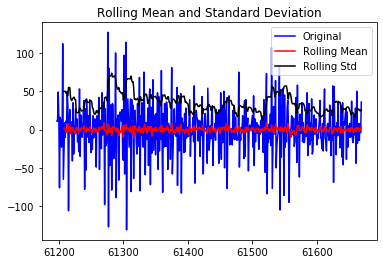

In [148]:
dftest(restaurant['visit_diff'].dropna(inplace=False))

Test Statistic          -19.658543
p-value                   0.000000
Lags Used                 0.000000
Observations Used       473.000000
Critical Value (1%)      -3.444251
Critical Value (5%)      -2.867670
Critical Value (10%)     -2.570035
dtype: float64


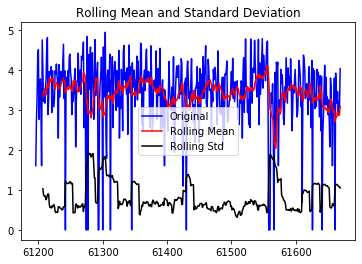

In [149]:
dftest(restaurant['log1p_visitors'].dropna(inplace=False))

Test Statistic         -6.182325e+00
p-value                 6.410651e-08
Lags Used               1.700000e+01
Observations Used       4.490000e+02
Critical Value (1%)    -3.444998e+00
Critical Value (5%)    -2.867999e+00
Critical Value (10%)   -2.570210e+00
dtype: float64


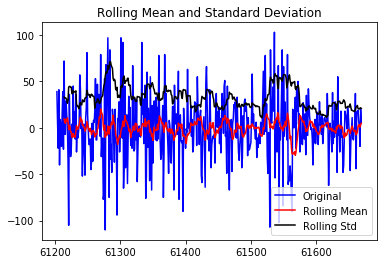

In [150]:
dftest(restaurant['visit_seasonal'].dropna(inplace=False))

Test Statistic         -1.170559e+01
p-value                 1.531724e-21
Lags Used               1.800000e+01
Observations Used       4.470000e+02
Critical Value (1%)    -3.445064e+00
Critical Value (5%)    -2.868028e+00
Critical Value (10%)   -2.570226e+00
dtype: float64


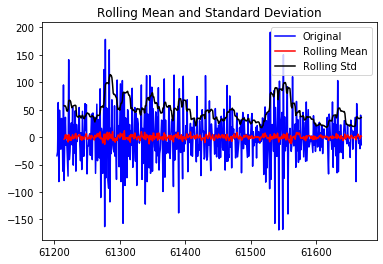

In [151]:
dftest(restaurant['visitors_seasonal_diff'].dropna(inplace=False))

In [152]:
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

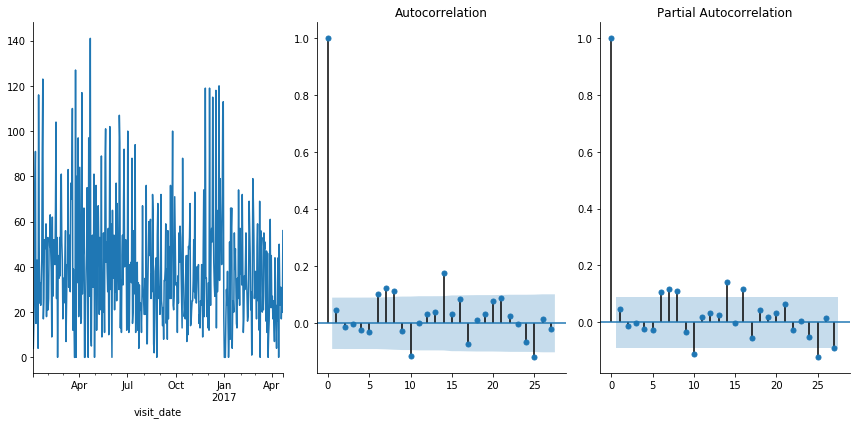

In [213]:
plots(restaurant['visitors'].dropna(inplace=False))

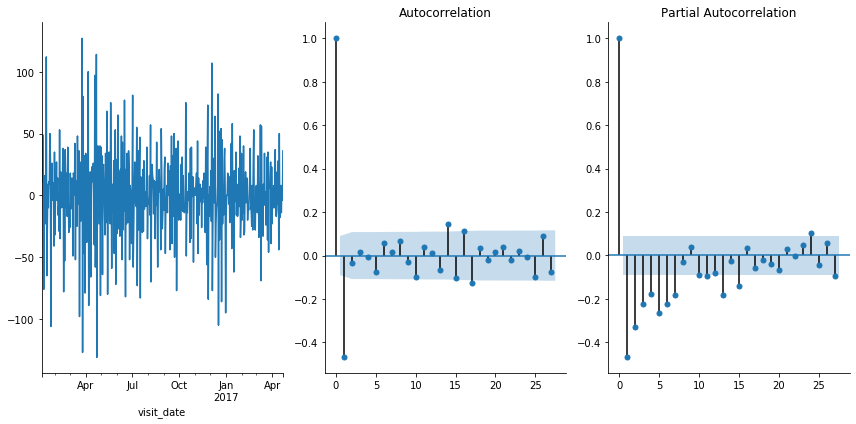

In [215]:
plots(restaurant['visit_diff'].dropna(inplace=False))

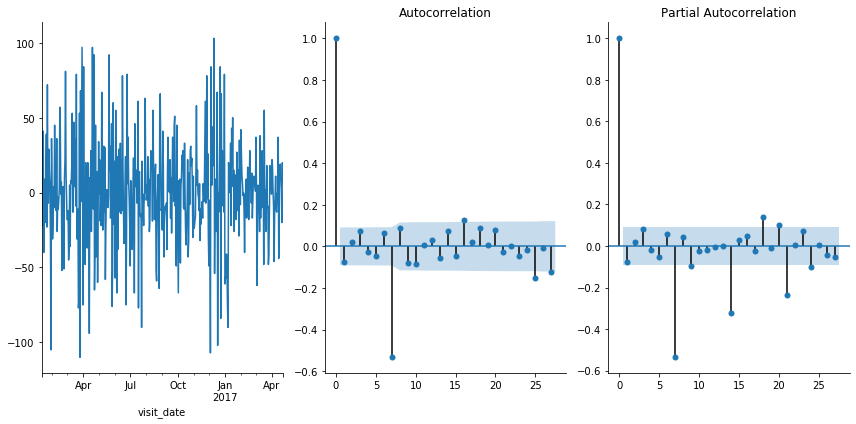

In [212]:
plots(restaurant['visit_seasonal'].dropna(inplace=False))

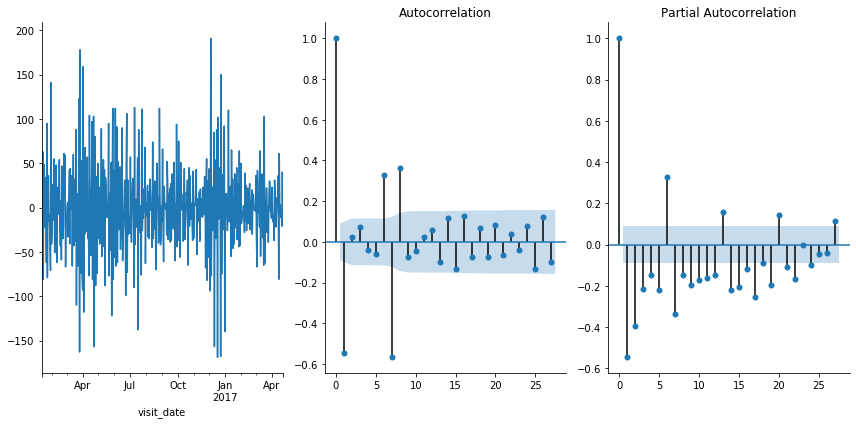

In [211]:
plots(restaurant['visitors_seasonal_diff'].dropna(inplace=False))

In [226]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 0, 2),
                                seasonal_order=(0, 1, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6061      0.016     98.813      0.000       1.574       1.638
ar.L2         -0.9732      0.011    -87.351      0.000      -0.995      -0.951
ma.L1         -1.6192      2.240     -0.723      0.470      -6.010       2.772
ma.L2          0.9999      2.773      0.361      0.718      -4.434       6.434
ma.S.L7       -2.0044      0.885     -2.266      0.023      -3.738      -0.271
ma.S.L14       1.0061      0.894      1.125      0.260      -0.746       2.758
sigma2       536.7666   1548.619      0.347      0.729   -2498.471    3572.004


//anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


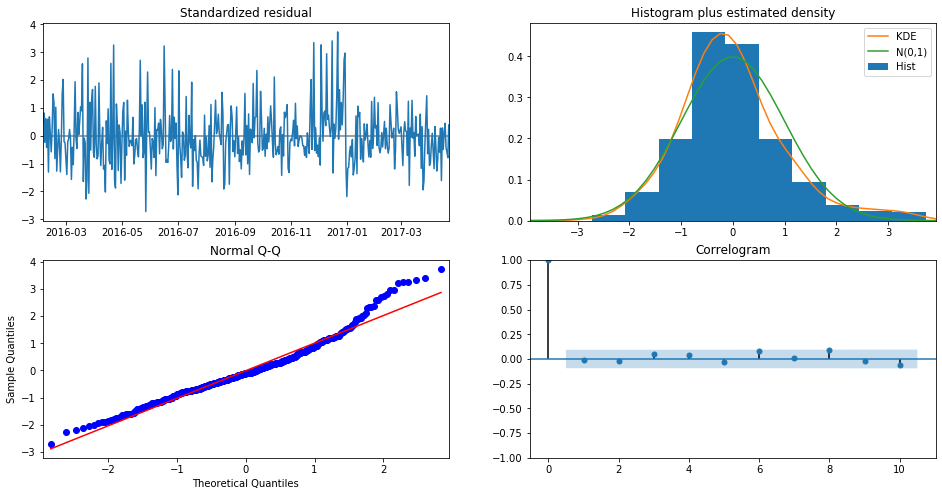

In [227]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

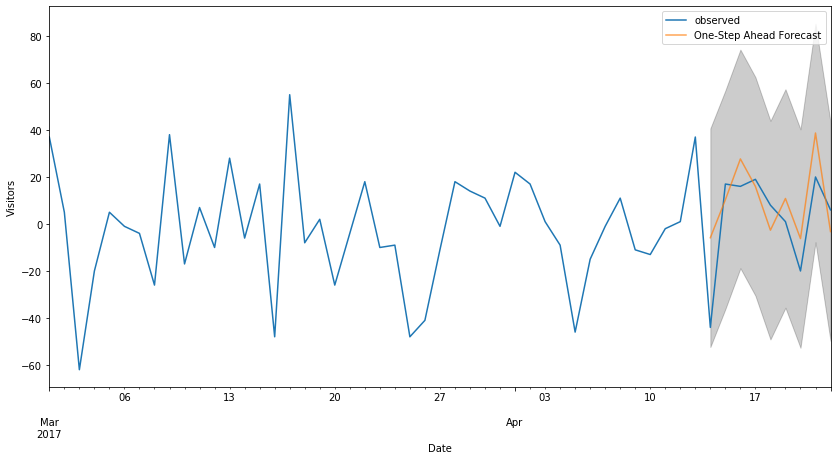

In [230]:
pred = results.get_prediction(start=pd.to_datetime('2017-04-14'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2017-03':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-Step Ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.legend()
plt.show()

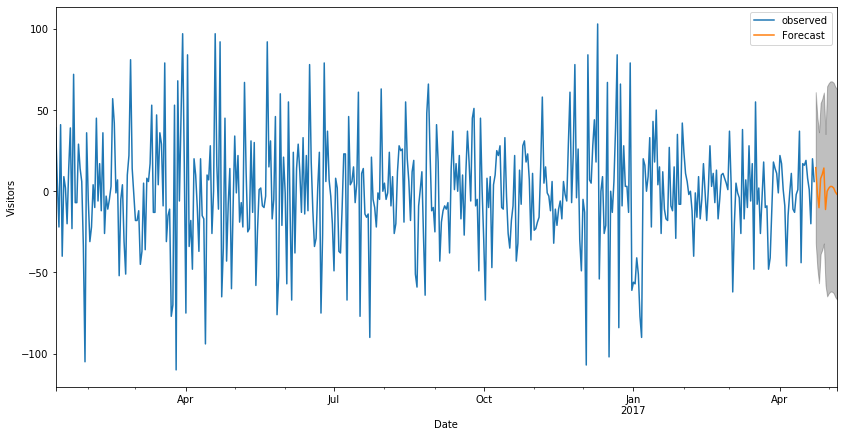

In [234]:
pred_uc = results.get_forecast(steps=14)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Visitors')
plt.legend()
plt.show()

## Prophet

In [423]:
from fbprophet import Prophet

In [424]:
prophet_df = restaurant.reset_index()

In [425]:
prophet_df = prophet_df.rename(columns={'visit_date': 'ds', 'visitors': 'y'})
prophet_df = prophet_df[['ds', 'y']]

In [426]:
prophet_df_train = prophet_df.loc[:460]
prophet_df_test = prophet_df.loc[460:]

In [427]:
holidays = date_info[['visit_date', 'is_holiday']]
holidays = holidays.rename(columns={'visit_date': 'ds', 'is_holiday': 'holidays'})

In [428]:
high_impact = pd.DataFrame({'holiday': 'High Impact',
                            'ds': pd.to_datetime(['2016-12-23', '2016-12-29', '2016-12-30', 
                                                  '2016-01-02', '2016-01-03', '2016-02-11', 
                                                 '2016-03-20', '2016-03-21', '2016-04-29',
                                                 '2016-05-03', '2016-05-04', '2017-12-23',
                                                  '2017-12-29', '2017-12-30', '2017-01-02', 
                                                  '2017-01-03', '2017-02-11', '2017-03-20',
                                                  '2017-03-21', '2017-04-29', '2017-05-03', '2017-05-04'])})

low_impact = pd.DataFrame({'holiday': 'Low Impact', 
                          'ds': pd.to_datetime(['2016-01-01', '2017-12-31'])})
holidays = pd.concat((low_impact, high_impact))

In [429]:
model = Prophet(weekly_seasonality=True, holidays=holidays)
model.add_country_holidays(country_name='Japan')
model.fit(prophet_df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [430]:
model_forecast = model.make_future_dataframe(periods=14)
model_forecast = model.predict(model_forecast)

<Figure size 1296x432 with 0 Axes>

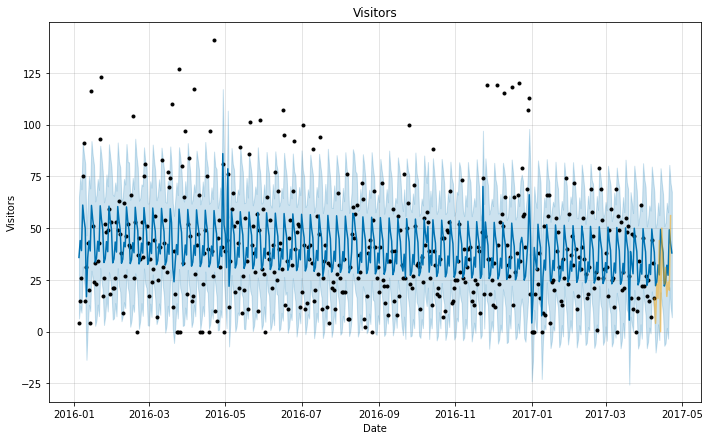

In [431]:
plt.figure(figsize=(18, 6))
model.plot(model_forecast, xlabel = 'Date', ylabel = 'Visitors')
plt.plot(prophet_df_test['ds'], prophet_df_test['y'], c='orange', alpha=0.5)
plt.title('Visitors');

## LSTM

In [377]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM

In [388]:
values = restaurant['log1p_visitors'].values.reshape(-1,1)
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [397]:
train_size = int(len(scaled) * 0.9)
test_size = len(scaled) - train_size

In [398]:
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]

In [399]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [400]:
X_train, y_train = create_dataset(train, look_back=1)
X_test, y_test = create_dataset(test, look_back=1)

425
47


In [418]:
X_train.shape

(425, 1, 1)

In [409]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [402]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=25, batch_size=100, validation_data=(X_test, y_test), 
                    verbose=1, shuffle=False)

model.summary()

Train on 425 samples, validate on 47 samples
Epoch 1/25
425/425 [==============================] - 2s 4ms/step - loss: 0.5363 - val_loss: 0.4172
Epoch 2/25
425/425 [==============================] - 0s 47us/step - loss: 0.4892 - val_loss: 0.3792
Epoch 3/25
425/425 [==============================] - 0s 48us/step - loss: 0.4446 - val_loss: 0.3431
Epoch 4/25
425/425 [==============================] - 0s 49us/step - loss: 0.4021 - val_loss: 0.3089
Epoch 5/25
425/425 [==============================] - 0s 52us/step - loss: 0.3615 - val_loss: 0.2761
Epoch 6/25
425/425 [==============================] - 0s 54us/step - loss: 0.3225 - val_loss: 0.2448
Epoch 7/25
425/425 [==============================] - 0s 48us/step - loss: 0.2849 - val_loss: 0.2149
Epoch 8/25
425/425 [==============================] - 0s 50us/step - loss: 0.2487 - val_loss: 0.1865
Epoch 9/25
425/425 [==============================] - 0s 49us/step - loss: 0.2141 - val_loss: 0.1599
Epoch 10/25
425/425 [==========================

In [403]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))

Train Root Mean Squared Error: 0.9396159977128409
Test Root Mean Squared Error: 1.1711229554052014


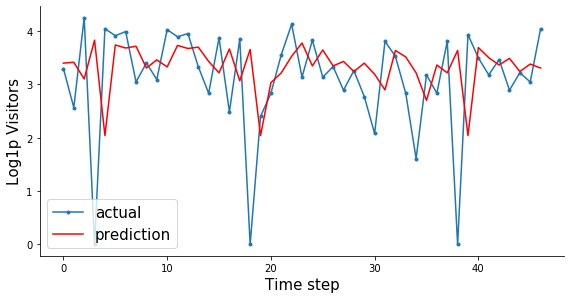

In [404]:
aa=[x for x in range(47)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Log1p Visitors', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [413]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [X_test[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        
    preds_moving = scaler.inverse_transform(np.array(preds_moving).reshape(-1,1))
    
    return preds_moving

In [414]:
preds_moving = moving_test_window_preds(14)

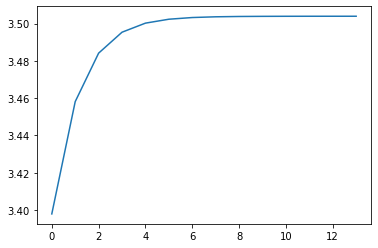

In [417]:
plt.plot(preds_moving)